# Load and preprocess data

In [1]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
from torchsummary import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [3]:
batch_size = 256
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # <-- Chuẩn ImageNet
    transforms.RandomErasing(p=0.75, scale=(0.01, 0.3), ratio=(1.0, 1.0), value=0, inplace=True),
])
train_set = CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform= transform
)
val_set = CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform= transform
)
train_loader = DataLoader(
    train_set,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 6
)
test_loader = DataLoader(
    val_set,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 6
)

100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [4]:
class CIFAR10_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CIFAR10_CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Downscale to 1x1
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

        # 🔥 Khởi tạo trọng số bằng He Initialization
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
model = CIFAR10_CNN()
model.to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [5]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
    accuracy = 100 * running_correct/total
    test_loss = test_loss/len(test_loader)
    return test_loss, accuracy

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = 1e-3)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def train(model, train_loader, test_loader, criterion, optimizer, lr_scheduler, max_epoch=50):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(max_epoch):
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epoch}", unit="batch")):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * running_correct / total
        epoch_loss = running_loss / (i+1)

        # Đánh giá trên tập kiểm tra
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Cập nhật learning rate bằng scheduler
        lr_scheduler.step(test_loss)  # Dùng test_loss làm input cho scheduler

        # In kết quả sau mỗi epoch
        print(f"Epoch [{epoch+1}/{max_epoch}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return train_losses, train_accuracies, test_losses, test_accuracies

In [8]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, train_loader, test_loader, criterion, optimizer, lr_scheduler, max_epoch=100)

Epoch 1/100: 100%|██████████| 196/196 [00:13<00:00, 14.76batch/s]


Epoch [1/100], Train Loss: 2.1699, Train Accuracy: 28.89%, Test Loss: 1.7721, Test Accuracy: 35.92%


Epoch 2/100: 100%|██████████| 196/196 [00:13<00:00, 14.57batch/s]


Epoch [2/100], Train Loss: 1.6152, Train Accuracy: 41.39%, Test Loss: 1.5210, Test Accuracy: 46.54%


Epoch 3/100: 100%|██████████| 196/196 [00:12<00:00, 15.11batch/s]


Epoch [3/100], Train Loss: 1.4232, Train Accuracy: 49.32%, Test Loss: 1.3410, Test Accuracy: 52.31%


Epoch 4/100: 100%|██████████| 196/196 [00:13<00:00, 14.48batch/s]


Epoch [4/100], Train Loss: 1.3037, Train Accuracy: 54.23%, Test Loss: 1.4206, Test Accuracy: 51.09%


Epoch 5/100: 100%|██████████| 196/196 [00:12<00:00, 15.29batch/s]


Epoch [5/100], Train Loss: 1.2084, Train Accuracy: 57.95%, Test Loss: 1.2200, Test Accuracy: 56.47%


Epoch 6/100: 100%|██████████| 196/196 [00:13<00:00, 14.56batch/s]


Epoch [6/100], Train Loss: 1.1247, Train Accuracy: 60.94%, Test Loss: 1.1132, Test Accuracy: 60.60%


Epoch 7/100: 100%|██████████| 196/196 [00:12<00:00, 15.16batch/s]


Epoch [7/100], Train Loss: 1.0535, Train Accuracy: 63.87%, Test Loss: 1.0193, Test Accuracy: 64.32%


Epoch 8/100: 100%|██████████| 196/196 [00:13<00:00, 14.63batch/s]


Epoch [8/100], Train Loss: 0.9996, Train Accuracy: 66.02%, Test Loss: 0.9289, Test Accuracy: 67.33%


Epoch 9/100: 100%|██████████| 196/196 [00:12<00:00, 15.14batch/s]


Epoch [9/100], Train Loss: 0.9592, Train Accuracy: 67.35%, Test Loss: 0.9316, Test Accuracy: 68.13%


Epoch 10/100: 100%|██████████| 196/196 [00:13<00:00, 14.67batch/s]


Epoch [10/100], Train Loss: 0.9233, Train Accuracy: 68.90%, Test Loss: 0.8797, Test Accuracy: 69.20%


Epoch 11/100: 100%|██████████| 196/196 [00:12<00:00, 15.10batch/s]


Epoch [11/100], Train Loss: 0.8891, Train Accuracy: 70.09%, Test Loss: 1.0039, Test Accuracy: 66.46%


Epoch 12/100: 100%|██████████| 196/196 [00:13<00:00, 14.73batch/s]


Epoch [12/100], Train Loss: 0.8509, Train Accuracy: 71.28%, Test Loss: 0.8412, Test Accuracy: 70.78%


Epoch 13/100: 100%|██████████| 196/196 [00:13<00:00, 15.06batch/s]


Epoch [13/100], Train Loss: 0.8195, Train Accuracy: 72.39%, Test Loss: 0.7443, Test Accuracy: 74.41%


Epoch 14/100: 100%|██████████| 196/196 [00:13<00:00, 14.47batch/s]


Epoch [14/100], Train Loss: 0.7973, Train Accuracy: 73.33%, Test Loss: 0.7788, Test Accuracy: 72.66%


Epoch 15/100: 100%|██████████| 196/196 [00:12<00:00, 15.34batch/s]


Epoch [15/100], Train Loss: 0.7759, Train Accuracy: 74.07%, Test Loss: 0.8509, Test Accuracy: 72.15%


Epoch 16/100: 100%|██████████| 196/196 [00:13<00:00, 14.65batch/s]


Epoch [16/100], Train Loss: 0.7509, Train Accuracy: 74.81%, Test Loss: 0.7202, Test Accuracy: 75.18%


Epoch 17/100: 100%|██████████| 196/196 [00:12<00:00, 15.44batch/s]


Epoch [17/100], Train Loss: 0.7325, Train Accuracy: 75.48%, Test Loss: 0.7091, Test Accuracy: 74.92%


Epoch 18/100: 100%|██████████| 196/196 [00:12<00:00, 15.10batch/s]


Epoch [18/100], Train Loss: 0.7166, Train Accuracy: 76.13%, Test Loss: 0.7435, Test Accuracy: 74.20%


Epoch 19/100: 100%|██████████| 196/196 [00:12<00:00, 15.28batch/s]


Epoch [19/100], Train Loss: 0.7020, Train Accuracy: 76.46%, Test Loss: 0.7773, Test Accuracy: 73.19%


Epoch 20/100: 100%|██████████| 196/196 [00:12<00:00, 15.36batch/s]


Epoch [20/100], Train Loss: 0.6792, Train Accuracy: 77.07%, Test Loss: 0.7506, Test Accuracy: 74.76%


Epoch 21/100: 100%|██████████| 196/196 [00:12<00:00, 15.31batch/s]


Epoch [21/100], Train Loss: 0.6656, Train Accuracy: 77.94%, Test Loss: 0.7915, Test Accuracy: 73.81%


Epoch 22/100: 100%|██████████| 196/196 [00:12<00:00, 15.20batch/s]


Epoch [22/100], Train Loss: 0.6491, Train Accuracy: 78.27%, Test Loss: 0.6366, Test Accuracy: 78.12%


Epoch 23/100: 100%|██████████| 196/196 [00:12<00:00, 15.10batch/s]


Epoch [23/100], Train Loss: 0.6399, Train Accuracy: 78.88%, Test Loss: 0.6581, Test Accuracy: 77.47%


Epoch 24/100: 100%|██████████| 196/196 [00:12<00:00, 15.22batch/s]


Epoch [24/100], Train Loss: 0.6179, Train Accuracy: 79.60%, Test Loss: 0.6637, Test Accuracy: 76.98%


Epoch 25/100: 100%|██████████| 196/196 [00:13<00:00, 14.86batch/s]


Epoch [25/100], Train Loss: 0.6170, Train Accuracy: 79.62%, Test Loss: 0.6298, Test Accuracy: 78.34%


Epoch 26/100: 100%|██████████| 196/196 [00:12<00:00, 15.21batch/s]


Epoch [26/100], Train Loss: 0.5942, Train Accuracy: 80.09%, Test Loss: 0.6975, Test Accuracy: 76.65%


Epoch 27/100: 100%|██████████| 196/196 [00:13<00:00, 14.85batch/s]


Epoch [27/100], Train Loss: 0.5860, Train Accuracy: 80.38%, Test Loss: 0.5829, Test Accuracy: 79.49%


Epoch 28/100: 100%|██████████| 196/196 [00:12<00:00, 15.33batch/s]


Epoch [28/100], Train Loss: 0.5730, Train Accuracy: 80.65%, Test Loss: 0.7480, Test Accuracy: 75.53%


Epoch 29/100: 100%|██████████| 196/196 [00:13<00:00, 14.69batch/s]


Epoch [29/100], Train Loss: 0.5649, Train Accuracy: 81.47%, Test Loss: 0.5970, Test Accuracy: 79.56%


Epoch 30/100: 100%|██████████| 196/196 [00:12<00:00, 15.16batch/s]


Epoch [30/100], Train Loss: 0.5642, Train Accuracy: 81.40%, Test Loss: 0.6285, Test Accuracy: 78.87%


Epoch 31/100: 100%|██████████| 196/196 [00:13<00:00, 14.67batch/s]


Epoch [31/100], Train Loss: 0.5450, Train Accuracy: 81.82%, Test Loss: 0.5457, Test Accuracy: 81.12%


Epoch 32/100: 100%|██████████| 196/196 [00:12<00:00, 15.23batch/s]


Epoch [32/100], Train Loss: 0.5444, Train Accuracy: 81.92%, Test Loss: 0.5421, Test Accuracy: 81.50%


Epoch 33/100: 100%|██████████| 196/196 [00:13<00:00, 14.72batch/s]


Epoch [33/100], Train Loss: 0.5238, Train Accuracy: 82.68%, Test Loss: 0.5510, Test Accuracy: 81.40%


Epoch 34/100: 100%|██████████| 196/196 [00:12<00:00, 15.31batch/s]


Epoch [34/100], Train Loss: 0.5151, Train Accuracy: 82.84%, Test Loss: 0.5711, Test Accuracy: 80.18%


Epoch 35/100: 100%|██████████| 196/196 [00:13<00:00, 14.57batch/s]


Epoch [35/100], Train Loss: 0.5132, Train Accuracy: 83.30%, Test Loss: 0.5509, Test Accuracy: 81.63%


Epoch 36/100: 100%|██████████| 196/196 [00:12<00:00, 15.37batch/s]


Epoch [36/100], Train Loss: 0.5077, Train Accuracy: 83.32%, Test Loss: 0.5772, Test Accuracy: 80.07%


Epoch 37/100: 100%|██████████| 196/196 [00:13<00:00, 14.64batch/s]


Epoch [37/100], Train Loss: 0.4933, Train Accuracy: 83.54%, Test Loss: 0.5615, Test Accuracy: 80.85%


Epoch 38/100: 100%|██████████| 196/196 [00:12<00:00, 15.27batch/s]


Epoch [38/100], Train Loss: 0.4881, Train Accuracy: 83.83%, Test Loss: 0.5664, Test Accuracy: 81.09%


Epoch 39/100: 100%|██████████| 196/196 [00:13<00:00, 14.65batch/s]


Epoch [39/100], Train Loss: 0.4832, Train Accuracy: 84.00%, Test Loss: 0.5995, Test Accuracy: 80.61%


Epoch 40/100: 100%|██████████| 196/196 [00:12<00:00, 15.21batch/s]


Epoch [40/100], Train Loss: 0.4749, Train Accuracy: 84.50%, Test Loss: 0.5554, Test Accuracy: 81.43%


Epoch 41/100: 100%|██████████| 196/196 [00:13<00:00, 14.54batch/s]


Epoch [41/100], Train Loss: 0.4662, Train Accuracy: 84.71%, Test Loss: 0.5360, Test Accuracy: 81.89%


Epoch 42/100: 100%|██████████| 196/196 [00:12<00:00, 15.25batch/s]


Epoch [42/100], Train Loss: 0.4604, Train Accuracy: 84.76%, Test Loss: 0.6458, Test Accuracy: 79.01%


Epoch 43/100: 100%|██████████| 196/196 [00:13<00:00, 14.71batch/s]


Epoch [43/100], Train Loss: 0.4550, Train Accuracy: 85.05%, Test Loss: 0.5200, Test Accuracy: 82.53%


Epoch 44/100: 100%|██████████| 196/196 [00:12<00:00, 15.19batch/s]


Epoch [44/100], Train Loss: 0.4467, Train Accuracy: 85.34%, Test Loss: 0.4988, Test Accuracy: 83.08%


Epoch 45/100: 100%|██████████| 196/196 [00:13<00:00, 14.62batch/s]


Epoch [45/100], Train Loss: 0.4432, Train Accuracy: 85.50%, Test Loss: 0.5248, Test Accuracy: 82.18%


Epoch 46/100: 100%|██████████| 196/196 [00:12<00:00, 15.09batch/s]


Epoch [46/100], Train Loss: 0.4368, Train Accuracy: 85.62%, Test Loss: 0.4964, Test Accuracy: 83.23%


Epoch 47/100: 100%|██████████| 196/196 [00:13<00:00, 14.79batch/s]


Epoch [47/100], Train Loss: 0.4305, Train Accuracy: 85.78%, Test Loss: 0.5344, Test Accuracy: 82.20%


Epoch 48/100: 100%|██████████| 196/196 [00:12<00:00, 15.25batch/s]


Epoch [48/100], Train Loss: 0.4255, Train Accuracy: 85.95%, Test Loss: 0.4927, Test Accuracy: 83.09%


Epoch 49/100: 100%|██████████| 196/196 [00:13<00:00, 14.65batch/s]


Epoch [49/100], Train Loss: 0.4185, Train Accuracy: 86.09%, Test Loss: 0.4902, Test Accuracy: 83.10%


Epoch 50/100: 100%|██████████| 196/196 [00:12<00:00, 15.12batch/s]


Epoch [50/100], Train Loss: 0.4147, Train Accuracy: 86.47%, Test Loss: 0.5147, Test Accuracy: 82.75%


Epoch 51/100: 100%|██████████| 196/196 [00:13<00:00, 14.62batch/s]


Epoch [51/100], Train Loss: 0.4045, Train Accuracy: 86.71%, Test Loss: 0.5190, Test Accuracy: 82.98%


Epoch 52/100: 100%|██████████| 196/196 [00:12<00:00, 15.28batch/s]


Epoch [52/100], Train Loss: 0.4062, Train Accuracy: 86.64%, Test Loss: 0.4931, Test Accuracy: 84.06%


Epoch 53/100: 100%|██████████| 196/196 [00:13<00:00, 14.76batch/s]


Epoch [53/100], Train Loss: 0.3971, Train Accuracy: 86.85%, Test Loss: 0.5138, Test Accuracy: 82.88%


Epoch 54/100: 100%|██████████| 196/196 [00:12<00:00, 15.26batch/s]


Epoch [54/100], Train Loss: 0.3978, Train Accuracy: 86.94%, Test Loss: 0.5062, Test Accuracy: 83.02%


Epoch 55/100: 100%|██████████| 196/196 [00:13<00:00, 15.05batch/s]


Epoch [55/100], Train Loss: 0.3845, Train Accuracy: 87.40%, Test Loss: 0.5082, Test Accuracy: 83.35%


Epoch 56/100: 100%|██████████| 196/196 [00:12<00:00, 15.26batch/s]


Epoch [56/100], Train Loss: 0.3818, Train Accuracy: 87.35%, Test Loss: 0.5299, Test Accuracy: 83.03%


Epoch 57/100: 100%|██████████| 196/196 [00:12<00:00, 15.15batch/s]


Epoch [57/100], Train Loss: 0.3849, Train Accuracy: 87.41%, Test Loss: 0.4966, Test Accuracy: 83.62%


Epoch 58/100: 100%|██████████| 196/196 [00:12<00:00, 15.16batch/s]


Epoch [58/100], Train Loss: 0.3708, Train Accuracy: 87.73%, Test Loss: 0.4946, Test Accuracy: 83.96%


Epoch 59/100: 100%|██████████| 196/196 [00:12<00:00, 15.29batch/s]


Epoch [59/100], Train Loss: 0.3715, Train Accuracy: 87.52%, Test Loss: 0.4860, Test Accuracy: 84.05%


Epoch 60/100: 100%|██████████| 196/196 [00:13<00:00, 14.90batch/s]


Epoch [60/100], Train Loss: 0.3713, Train Accuracy: 87.63%, Test Loss: 0.4654, Test Accuracy: 84.57%


Epoch 61/100: 100%|██████████| 196/196 [00:12<00:00, 15.29batch/s]


Epoch [61/100], Train Loss: 0.3678, Train Accuracy: 87.89%, Test Loss: 0.4983, Test Accuracy: 83.58%


Epoch 62/100: 100%|██████████| 196/196 [00:13<00:00, 14.81batch/s]


Epoch [62/100], Train Loss: 0.3607, Train Accuracy: 88.02%, Test Loss: 0.4692, Test Accuracy: 84.76%


Epoch 63/100: 100%|██████████| 196/196 [00:12<00:00, 15.31batch/s]


Epoch [63/100], Train Loss: 0.3540, Train Accuracy: 88.18%, Test Loss: 0.5084, Test Accuracy: 84.22%


Epoch 64/100: 100%|██████████| 196/196 [00:13<00:00, 14.81batch/s]


Epoch [64/100], Train Loss: 0.3496, Train Accuracy: 88.29%, Test Loss: 0.5218, Test Accuracy: 83.76%


Epoch 65/100: 100%|██████████| 196/196 [00:12<00:00, 15.11batch/s]


Epoch [65/100], Train Loss: 0.3508, Train Accuracy: 88.42%, Test Loss: 0.4601, Test Accuracy: 84.95%


Epoch 66/100: 100%|██████████| 196/196 [00:13<00:00, 14.46batch/s]


Epoch [66/100], Train Loss: 0.3418, Train Accuracy: 88.65%, Test Loss: 0.4614, Test Accuracy: 84.82%


Epoch 67/100: 100%|██████████| 196/196 [00:13<00:00, 15.06batch/s]


Epoch [67/100], Train Loss: 0.3474, Train Accuracy: 88.51%, Test Loss: 0.4542, Test Accuracy: 85.44%


Epoch 68/100: 100%|██████████| 196/196 [00:13<00:00, 14.81batch/s]


Epoch [68/100], Train Loss: 0.3283, Train Accuracy: 89.10%, Test Loss: 0.4838, Test Accuracy: 84.33%


Epoch 69/100: 100%|██████████| 196/196 [00:12<00:00, 15.23batch/s]


Epoch [69/100], Train Loss: 0.3249, Train Accuracy: 89.14%, Test Loss: 0.4546, Test Accuracy: 84.92%


Epoch 70/100: 100%|██████████| 196/196 [00:13<00:00, 14.84batch/s]


Epoch [70/100], Train Loss: 0.3256, Train Accuracy: 89.26%, Test Loss: 0.4879, Test Accuracy: 84.40%


Epoch 71/100: 100%|██████████| 196/196 [00:12<00:00, 15.12batch/s]


Epoch [71/100], Train Loss: 0.3274, Train Accuracy: 89.09%, Test Loss: 0.4687, Test Accuracy: 85.03%


Epoch 72/100: 100%|██████████| 196/196 [00:13<00:00, 14.63batch/s]


Epoch [72/100], Train Loss: 0.3240, Train Accuracy: 89.32%, Test Loss: 0.4726, Test Accuracy: 85.45%


Epoch 73/100: 100%|██████████| 196/196 [00:12<00:00, 15.25batch/s]


Epoch [73/100], Train Loss: 0.3204, Train Accuracy: 89.30%, Test Loss: 0.4877, Test Accuracy: 84.26%


Epoch 74/100: 100%|██████████| 196/196 [00:13<00:00, 14.79batch/s]


Epoch [74/100], Train Loss: 0.3151, Train Accuracy: 89.55%, Test Loss: 0.4707, Test Accuracy: 84.86%


Epoch 75/100: 100%|██████████| 196/196 [00:12<00:00, 15.12batch/s]


Epoch [75/100], Train Loss: 0.3137, Train Accuracy: 89.48%, Test Loss: 0.4855, Test Accuracy: 84.62%


Epoch 76/100: 100%|██████████| 196/196 [00:13<00:00, 14.64batch/s]


Epoch [76/100], Train Loss: 0.3084, Train Accuracy: 89.76%, Test Loss: 0.5071, Test Accuracy: 83.80%


Epoch 77/100: 100%|██████████| 196/196 [00:12<00:00, 15.17batch/s]


Epoch [77/100], Train Loss: 0.3038, Train Accuracy: 89.83%, Test Loss: 0.4395, Test Accuracy: 85.35%


Epoch 78/100: 100%|██████████| 196/196 [00:13<00:00, 14.78batch/s]


Epoch [78/100], Train Loss: 0.3068, Train Accuracy: 89.90%, Test Loss: 0.4682, Test Accuracy: 85.49%


Epoch 79/100: 100%|██████████| 196/196 [00:12<00:00, 15.10batch/s]


Epoch [79/100], Train Loss: 0.3002, Train Accuracy: 90.15%, Test Loss: 0.4465, Test Accuracy: 85.13%


Epoch 80/100: 100%|██████████| 196/196 [00:13<00:00, 14.81batch/s]


Epoch [80/100], Train Loss: 0.2982, Train Accuracy: 90.07%, Test Loss: 0.4723, Test Accuracy: 85.44%


Epoch 81/100: 100%|██████████| 196/196 [00:13<00:00, 15.03batch/s]


Epoch [81/100], Train Loss: 0.2934, Train Accuracy: 90.22%, Test Loss: 0.4231, Test Accuracy: 85.98%


Epoch 82/100: 100%|██████████| 196/196 [00:13<00:00, 14.61batch/s]


Epoch [82/100], Train Loss: 0.2945, Train Accuracy: 90.24%, Test Loss: 0.4633, Test Accuracy: 85.18%


Epoch 83/100: 100%|██████████| 196/196 [00:12<00:00, 15.11batch/s]


Epoch [83/100], Train Loss: 0.2909, Train Accuracy: 90.25%, Test Loss: 0.4695, Test Accuracy: 84.84%


Epoch 84/100: 100%|██████████| 196/196 [00:13<00:00, 14.74batch/s]


Epoch [84/100], Train Loss: 0.2896, Train Accuracy: 90.31%, Test Loss: 0.4302, Test Accuracy: 86.42%


Epoch 85/100: 100%|██████████| 196/196 [00:13<00:00, 14.98batch/s]


Epoch [85/100], Train Loss: 0.2880, Train Accuracy: 90.46%, Test Loss: 0.4656, Test Accuracy: 85.36%


Epoch 86/100: 100%|██████████| 196/196 [00:13<00:00, 14.48batch/s]


Epoch [86/100], Train Loss: 0.2832, Train Accuracy: 90.60%, Test Loss: 0.4467, Test Accuracy: 86.18%


Epoch 87/100: 100%|██████████| 196/196 [00:13<00:00, 15.07batch/s]


Epoch [87/100], Train Loss: 0.2812, Train Accuracy: 90.65%, Test Loss: 0.4492, Test Accuracy: 85.35%


Epoch 88/100: 100%|██████████| 196/196 [00:13<00:00, 14.71batch/s]


Epoch [88/100], Train Loss: 0.2819, Train Accuracy: 90.63%, Test Loss: 0.4498, Test Accuracy: 85.90%


Epoch 89/100: 100%|██████████| 196/196 [00:12<00:00, 15.10batch/s]


Epoch [89/100], Train Loss: 0.2745, Train Accuracy: 90.87%, Test Loss: 0.4810, Test Accuracy: 85.18%


Epoch 90/100: 100%|██████████| 196/196 [00:13<00:00, 14.98batch/s]


Epoch [90/100], Train Loss: 0.2740, Train Accuracy: 90.95%, Test Loss: 0.4507, Test Accuracy: 85.72%


Epoch 91/100: 100%|██████████| 196/196 [00:13<00:00, 15.01batch/s]


Epoch [91/100], Train Loss: 0.2713, Train Accuracy: 91.11%, Test Loss: 0.4621, Test Accuracy: 86.00%


Epoch 92/100: 100%|██████████| 196/196 [00:12<00:00, 15.49batch/s]


Epoch [92/100], Train Loss: 0.2709, Train Accuracy: 90.96%, Test Loss: 0.4712, Test Accuracy: 85.66%


Epoch 93/100: 100%|██████████| 196/196 [00:12<00:00, 15.08batch/s]


Epoch [93/100], Train Loss: 0.2316, Train Accuracy: 92.34%, Test Loss: 0.4059, Test Accuracy: 87.67%


Epoch 94/100: 100%|██████████| 196/196 [00:12<00:00, 15.42batch/s]


Epoch [94/100], Train Loss: 0.2231, Train Accuracy: 92.55%, Test Loss: 0.3870, Test Accuracy: 87.79%


Epoch 95/100: 100%|██████████| 196/196 [00:13<00:00, 15.06batch/s]


Epoch [95/100], Train Loss: 0.2156, Train Accuracy: 92.91%, Test Loss: 0.4067, Test Accuracy: 87.52%


Epoch 96/100: 100%|██████████| 196/196 [00:12<00:00, 15.37batch/s]


Epoch [96/100], Train Loss: 0.2124, Train Accuracy: 92.80%, Test Loss: 0.3903, Test Accuracy: 88.17%


Epoch 97/100: 100%|██████████| 196/196 [00:13<00:00, 14.93batch/s]


Epoch [97/100], Train Loss: 0.2129, Train Accuracy: 92.94%, Test Loss: 0.4080, Test Accuracy: 87.65%


Epoch 98/100: 100%|██████████| 196/196 [00:13<00:00, 14.84batch/s]


Epoch [98/100], Train Loss: 0.2113, Train Accuracy: 93.03%, Test Loss: 0.3970, Test Accuracy: 87.34%


Epoch 99/100: 100%|██████████| 196/196 [00:13<00:00, 14.72batch/s]


Epoch [99/100], Train Loss: 0.2017, Train Accuracy: 93.31%, Test Loss: 0.3930, Test Accuracy: 87.70%


Epoch 100/100: 100%|██████████| 196/196 [00:12<00:00, 15.09batch/s]


Epoch [100/100], Train Loss: 0.2016, Train Accuracy: 93.32%, Test Loss: 0.3949, Test Accuracy: 88.05%


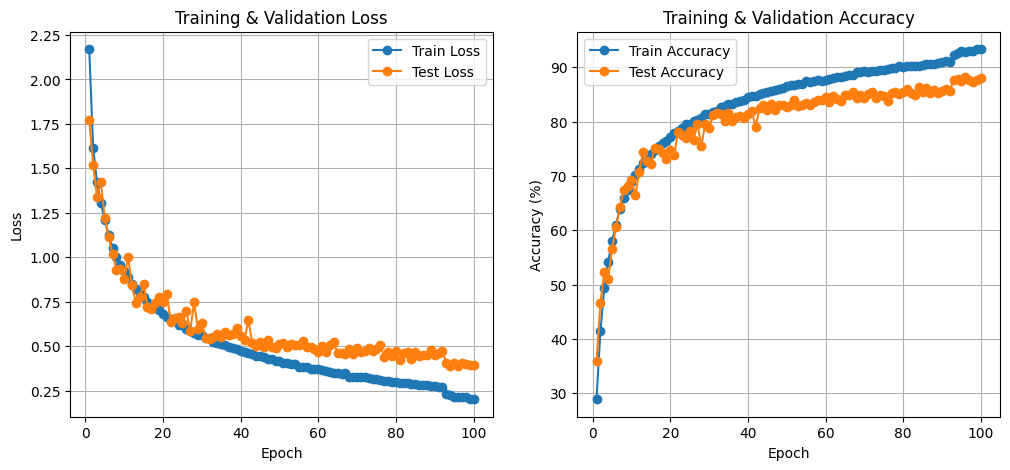

In [9]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Vẽ loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, test_losses, label="Test Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()

# Vẽ accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
plt.plot(epochs, test_accuracies, label="Test Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid()

plt.show()

In [10]:
save_path = './model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./model.pth
